In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
import shap

In [3]:
df = pd.read_csv("churn_telecom.csv")

In [4]:
df["TotalCharges"] = df["TotalCharges"].replace(" ", 0)

In [5]:
df["TotalCharges"] = df["TotalCharges"].astype(float)

# Machine Learning

In [6]:
X = df.drop(columns=["Churn", "customerID"])
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

### Pipeline

In [7]:
col_cat = X.drop(columns=['TotalCharges', 'tenure', 'MonthlyCharges']).columns
col_num = X[['TotalCharges', 'tenure', 'MonthlyCharges']].columns

In [8]:
categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [9]:
numerical_transformer = Pipeline(steps=[
        ("scaler", StandardScaler())
])

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, col_cat),
        ('num', numerical_transformer, col_num)  # Pas de transformation pour les colonnes numériques
    ])

In [11]:
model = Pipeline(steps=[
    ('LogReg', LogisticRegression())
])

In [12]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

### Attribuer un nom aux colonnes

In [13]:
len(col_names)

NameError: name 'col_names' is not defined

In [14]:
col_names = preprocessor.get_feature_names_out()

In [15]:
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns = col_names)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns = col_names)

In [16]:
model.fit(X_train_preprocessed, y_train)

Pipeline(steps=[('LogReg', LogisticRegression())])

### Evaluer la performance

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

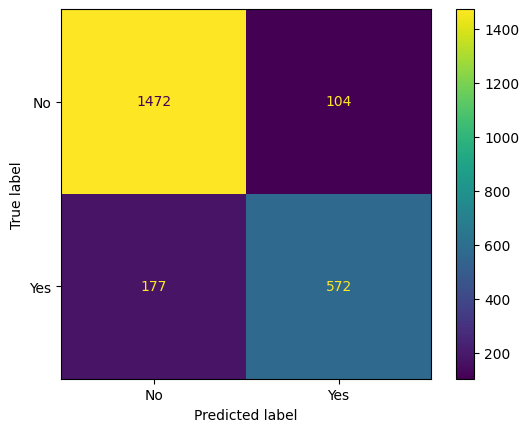

In [18]:
predictions = model.predict(X_test_preprocessed)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

Résultat:

1463 personnes qui sont restées ont été prédites comme "Reste" par le modèle.


184 personnes qui ont résiliées ont été prédites comme "Reste" par le modèle.


565 personnes qui ont résiliés ont été prédites comme "Résilie" par le modèle.


113 personnes qui qont restées ont été prédites comme "Résilie" par le modèle.


In [19]:
F1 = model.score(X_test_preprocessed, y_test)

In [20]:
F1

0.8791397849462366

### Utiliser SHAP

In [21]:
model

Pipeline(steps=[('LogReg', LogisticRegression())])

In [22]:
shap.initjs()
logreg = model.named_steps['LogReg']
explainer = shap.Explainer(logreg, X_train_preprocessed)
shap_values = explainer(X_test_preprocessed)

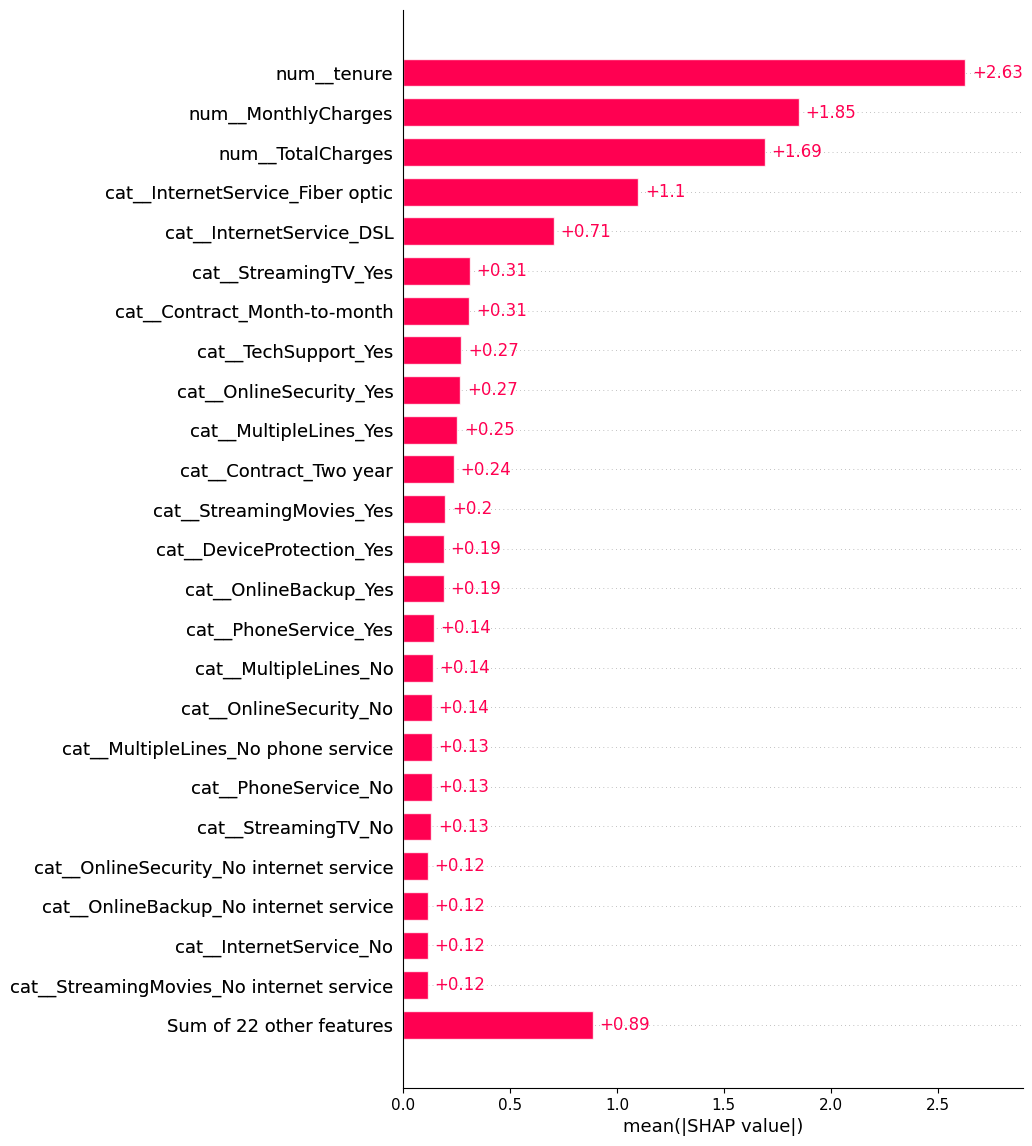

In [23]:
shap.plots.bar(shap_values[:,:,0],max_display=25)

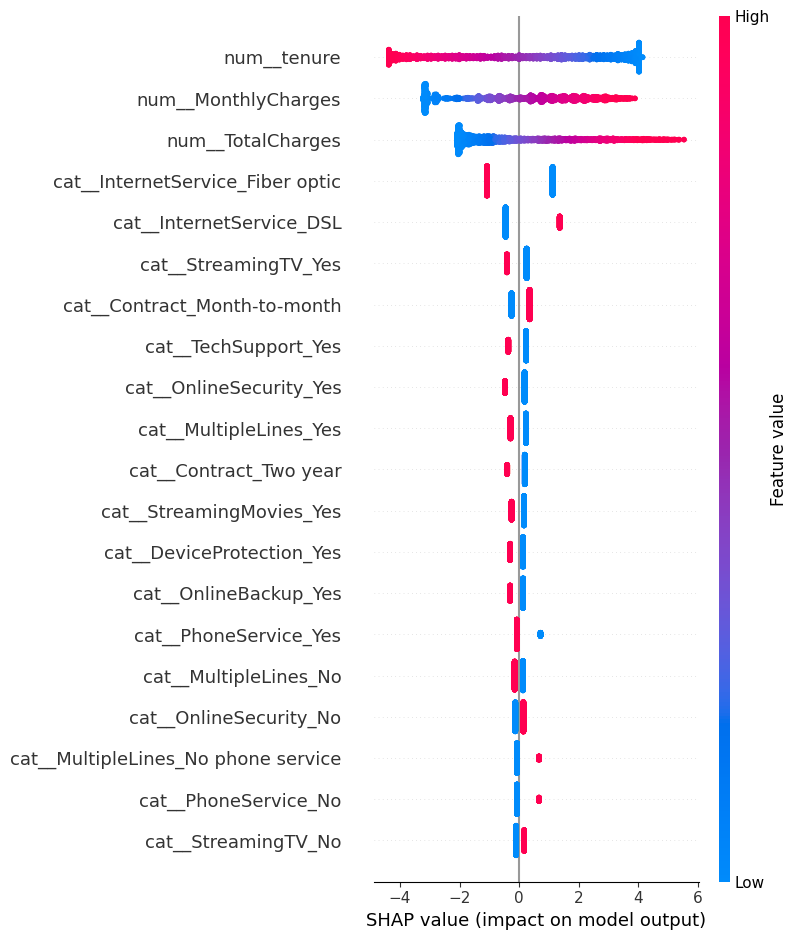

In [24]:
shap.summary_plot(shap_values, X_test_preprocessed)

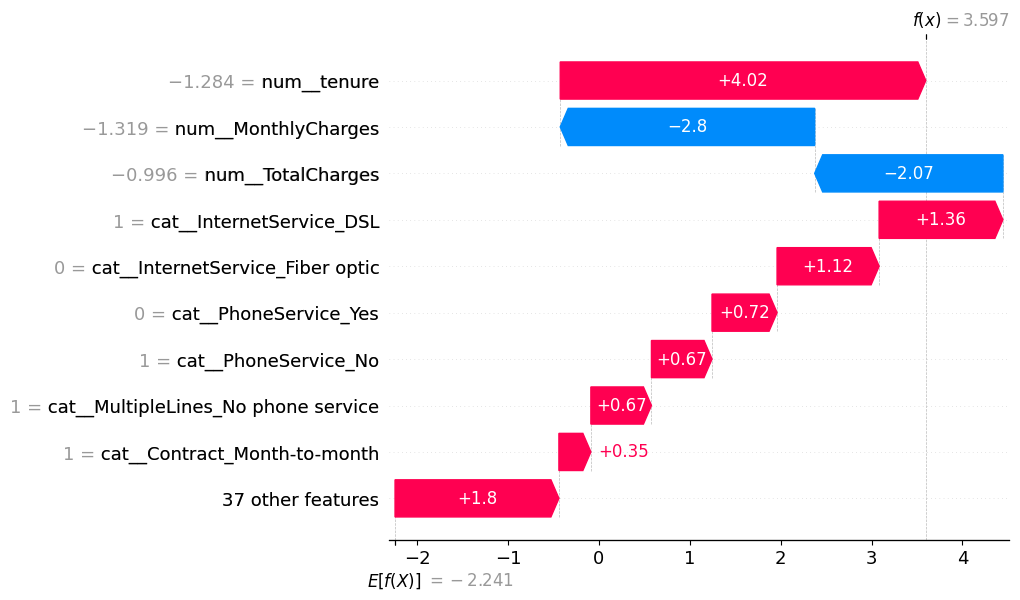

In [25]:
shap.plots.waterfall(shap_values[0,:,0])

### Calculer le score de prédiction

In [26]:
X_preprocessed = preprocessor.transform(X)

In [27]:
prediction = pd.DataFrame(
    model.predict_proba(X_preprocessed),
    columns=model.classes_
)

/home/luna/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [28]:
df["Score_résiliation"] = round(prediction["Yes"]*100,2)

In [29]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Score_résiliation
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Yes,36.82
1,5575-GNVDE,Male,0,No,No,34,Yes,No,Fiber optic,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0.58
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,83.08
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,Fiber optic,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.25
4,9237-HQITU,Female,0,No,No,2,Yes,No,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,98.79


### Export score

In [31]:
#df.to_csv("churn_telecom_scoring.csv")